# Import Ntuple

In [1]:
%load_ext autoreload
%autoreload 2

import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util

training_variables = util.training_variables
columns = util.all_relevant_variables

In [2]:
# 4S Data vs MC

cut = '(5<B0_roeMbc_my_mask) & (-4<B0_roeDeltae_my_mask) & (B0_roeDeltae_my_mask<1) & (B0_dr<0.1)'

# (DstVeto_massDiff_0<0.135 or 0.145<DstVeto_massDiff_0) and 1.855<D_M<1.885

lgb_tight = 'sig_prob>0.6 and fakeD_prob<0.06 and continuum_prob<0.05 and combinatorial_prob<0.2'
lgb_loose = 'sig_prob>0.6 and fakeD_prob<0.5 and continuum_prob<0.5 and combinatorial_prob<0.5'
lgb_comb = 'fakeD_prob<0.1 and continuum_prob<0.1 and combinatorial_prob>0.7'

# Load data files
MC_4S_loose = uproot.concatenate(['../../Samples/MC16rd/e_channel/lgb_loose_BDT1.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

data_4S_loose = uproot.concatenate(['../../Samples/Data/e_channel/proc16_4S_lgb_loose_BDT1.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

df_mc_4S_loose = pd.DataFrame(MC_4S_loose)
df_data_4S_loose = pd.DataFrame(data_4S_loose)

In [32]:
columns += ['B0_CMS3_weQ2lnuSimple']

MC15ri_4S = uproot.concatenate(['../../Samples/MC15ri/e_channel/local_200fb_control/*.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

df_mc15ri_4S = pd.DataFrame(MC15ri_4S)

for df in [df_mc15ri_4S,]:
    # df.eval(f'cos_D_l = (D_px*ell_px + D_py*ell_py + D_pz*ell_pz)/(D_p*ell_p)', inplace=True)
    df.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
    df.eval('p_D_l = D_CMS_p + ell_CMS_p', inplace=True)

df_mc15ri_4S_lgb = util.apply_mva_bcs(df_mc15ri_4S, training_variables, lgb_loose, library='lgbm')
df_mc15ri_4S_lgb['B0_recQ2BhSimple'] = df_mc15ri_4S_lgb['B0_CMS3_weQ2lnuSimple']
samples_mc15ri_4S=util.classify_mc_dict(df_mc15ri_4S_lgb, 'e', template=False)
mpl_mc15ri_4S=util.mpl(samples_mc15ri_4S,df_data_4S_loose)

In [3]:
samples=util.classify_mc_dict(df_mc_4S_loose, 'e', template=False)
comb_subcat = util.classify_combinatorial(samples['bkg_combinatorial'],merge=True)

samples_subcat = samples.copy()
samples_subcat.update({'bkg_combinatorial': pd.DataFrame(columns=columns)})
samples_subcat.update(comb_subcat)
samples_subcat.pop('bkg_combinatorial')

mpl_mc=util.mpl(samples)
mpl=util.mpl(samples, df_data_4S_loose)
mpl_subcat=util.mpl(samples_subcat, df_data_4S_loose)

In [19]:
for name, df in samples_subcat.items():
    print(name, len(df))

bkg_fakeD 556157
bkg_TDFl 4543
bkg_fakeTracks 11984
bkg_continuum 43915
bkg_singleBbkg 37651
bkg_other_TDTl 0
$D\tau\nu$ 14869
$D^\ast\tau\nu$ 8945
$D\ell\nu$ 266171
$D^\ast\ell\nu$ 188045
$D^{\ast\ast}\tau\nu$ 5815
$D^{\ast\ast}\ell\nu$_narrow 60742
$D^{\ast\ast}\ell\nu$_broad 43735
$D\ell\nu$_gap_pi 12114
$D\ell\nu$_gap_eta 10283
bkg_other_signal 0
SemileptonicB2D_PrimaryLepton 636
SemileptonicB2D_SecondaryLepton + HadronicB2D_PrimaryLepton 27644
HadronicB2D_SecondaryLepton 32676
others 0


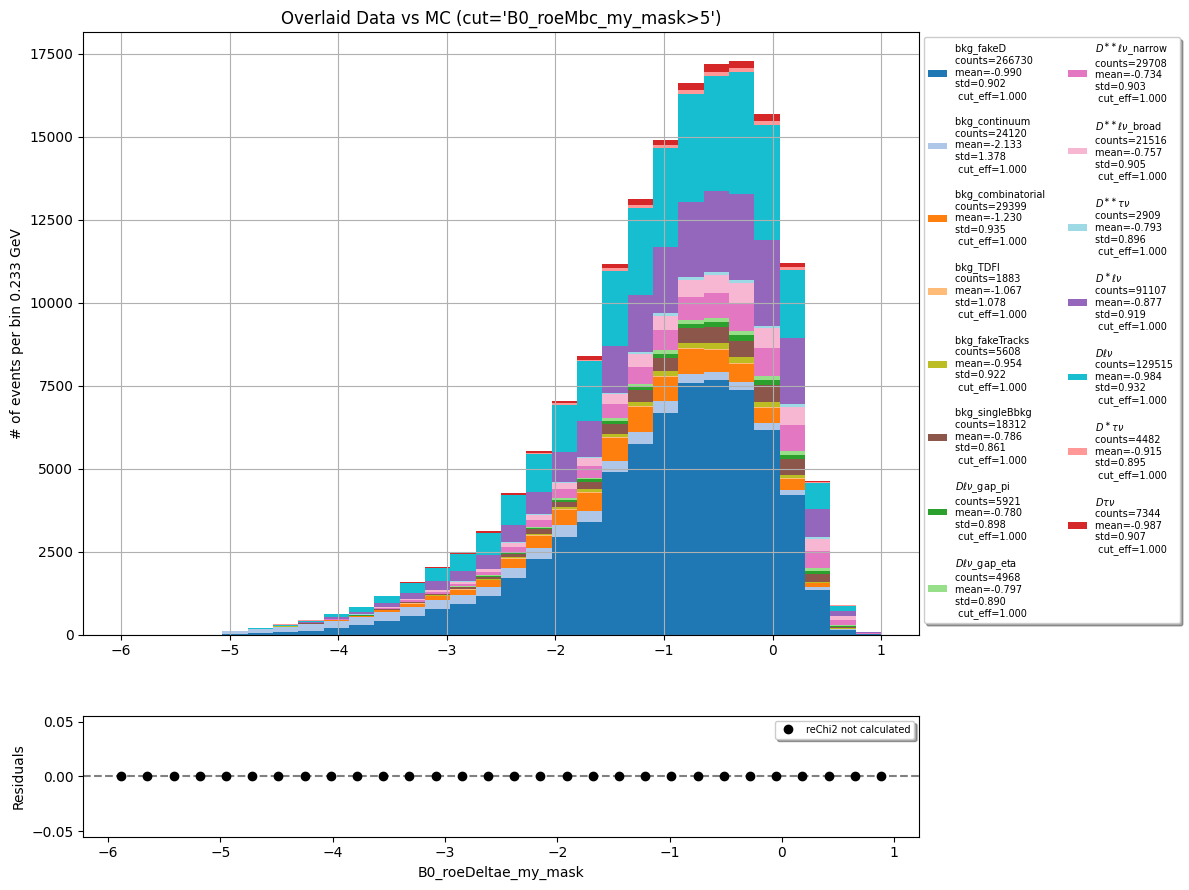

In [71]:
# showing the fake D and sidebands in D_M
b1 = np.linspace(-6,1,31)
weights={'all_mc':0.25}
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='B0_roeDeltae_my_mask',bins=b1,cut='B0_roeMbc_my_mask>5',correction=False,mask=[],
    figsize=(12,9),ratio=False,legend_nc=2,legend_fs=7, weights=weights)

In [63]:
samples=util.classify_mc_dict(df_mc_4S_lgb, 'mu', template=False)
mpl=util.mpl(samples,df_data_4S_lgb)

for name, df in samples.items():
    print(name, len(df))

bkg_fakeD 45771
bkg_TDFl 10862
bkg_fakeTracks 1446
bkg_continuum 5834
bkg_combinatorial 5465
bkg_singleBbkg 2589
bkg_other_TDTl 0
$D\tau\nu$ 883
$D^\ast\tau\nu$ 572
$D\ell\nu$ 25776
$D^\ast\ell\nu$ 17806
$D^{\ast\ast}\tau\nu$ 402
$D^{\ast\ast}\ell\nu$_narrow 5842
$D^{\ast\ast}\ell\nu$_broad 4341
$D\ell\nu$_gap_pi 1212
$D\ell\nu$_gap_eta 1071
bkg_other_signal 0


# Control regions

### 1. q^2 < 3

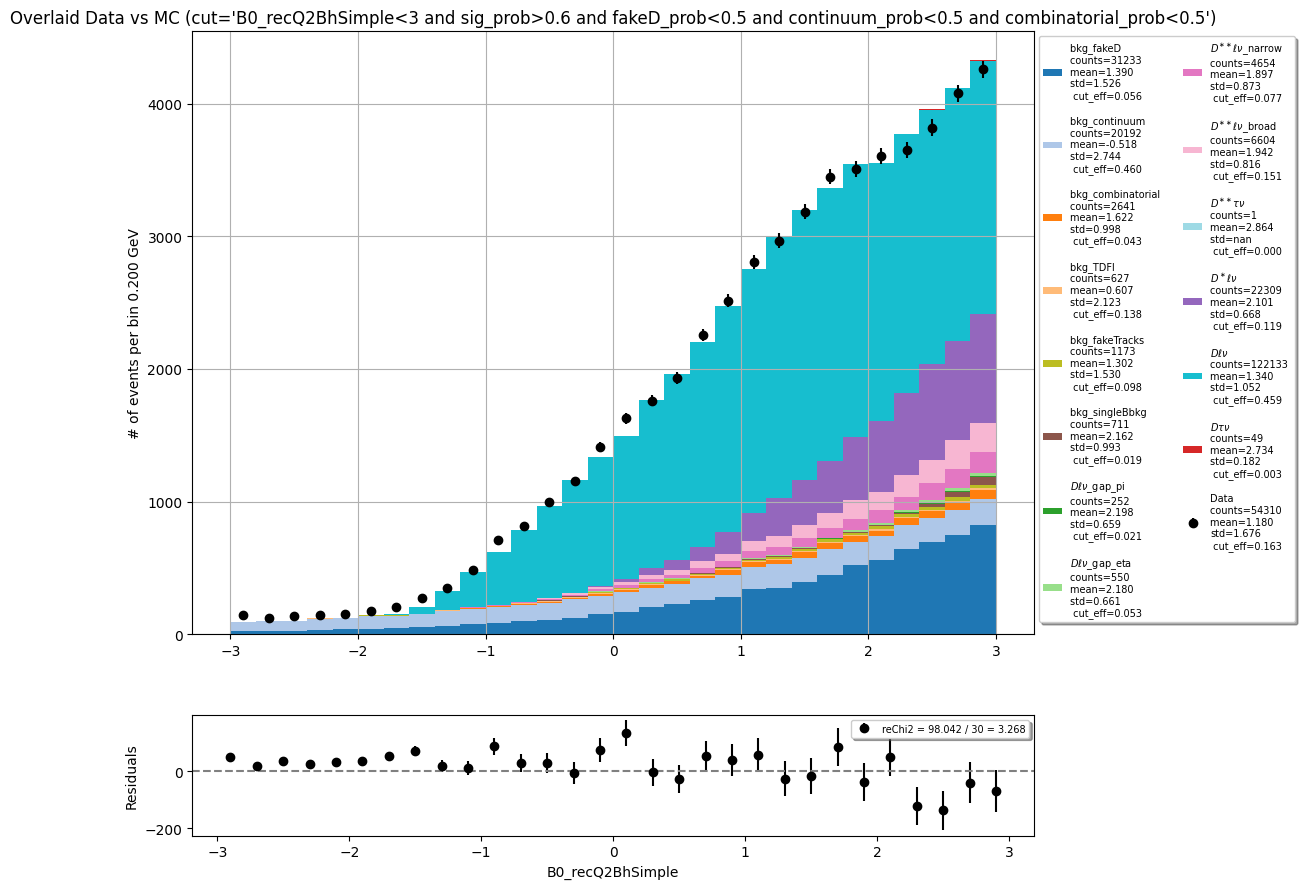

In [8]:
# showing the fake D and sidebands in D_M
b1 = np.linspace(-3,3,31)
weights={'all_mc':0.25}
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='B0_recQ2BhSimple',bins=b1,cut=f'B0_recQ2BhSimple<3 and {lgb_tight}',correction=False,mask=[],
    figsize=(12,9),ratio=False,legend_nc=2,legend_fs=7,weights=weights)

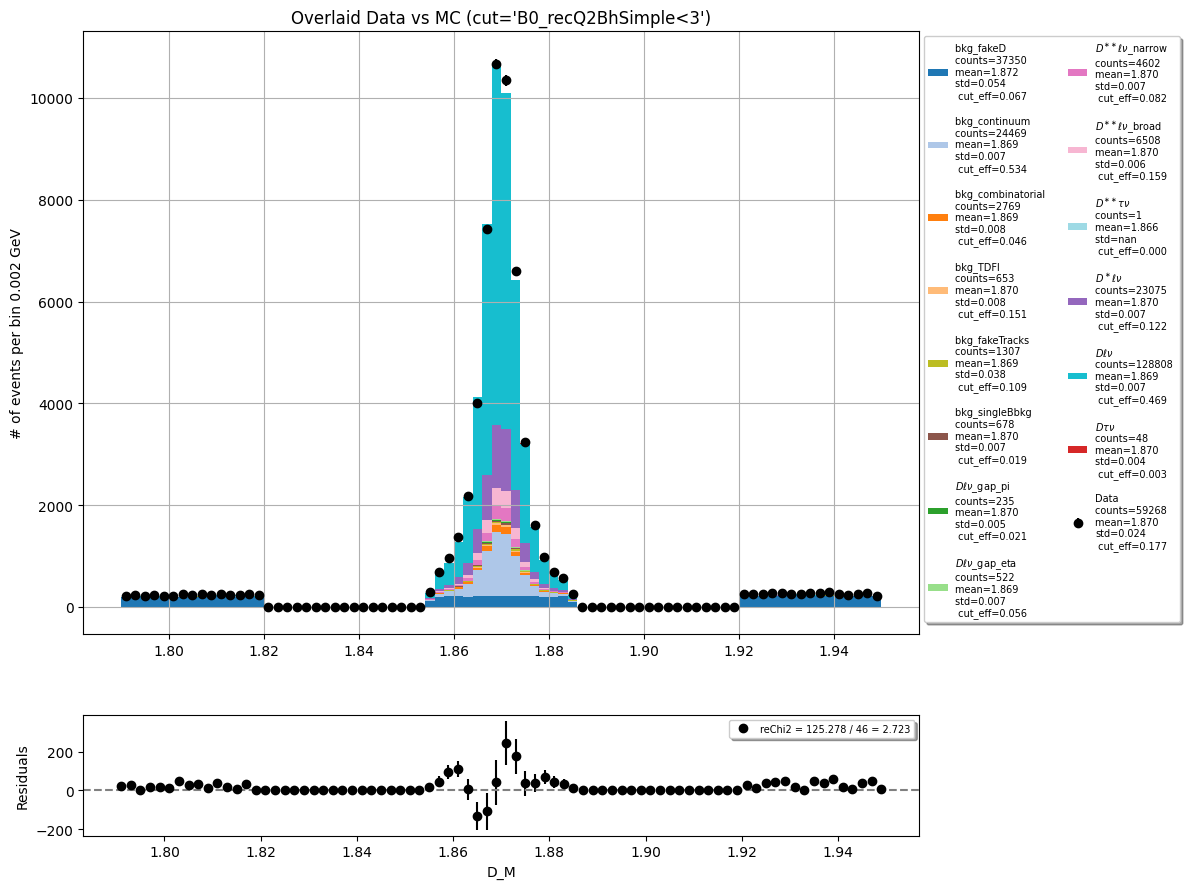

In [12]:
# MC16rd
b1 = np.linspace(1.79,1.95,81)
weights={'all_mc':0.25}
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='D_M',bins=b1,cut=f'B0_recQ2BhSimple<3 and {lgb_tight}',correction=False,mask=[],
    figsize=(12,9),ratio=False,legend_nc=2,legend_fs=7,weights=weights)

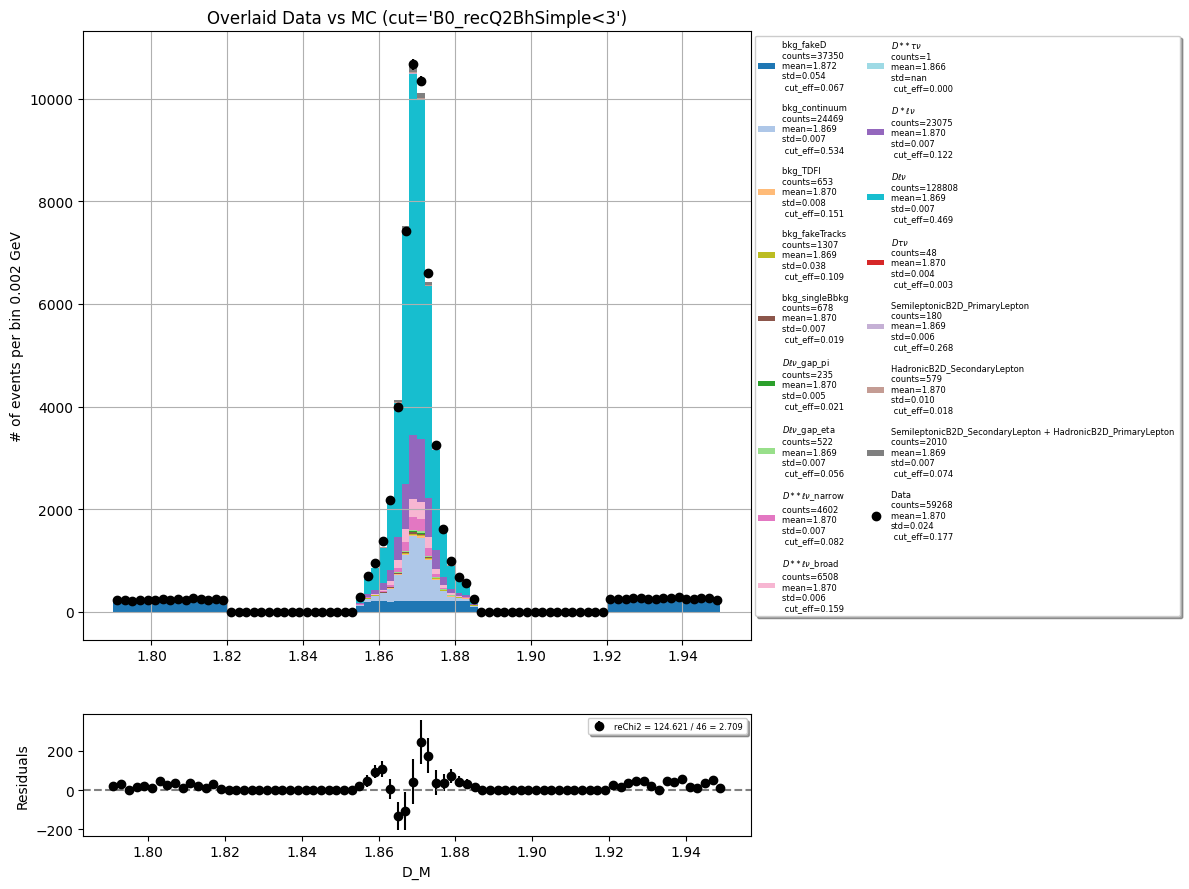

In [36]:
# MC16rd
b1 = np.linspace(1.79,1.95,81)
weights={'all_mc':0.25}
data_hist_all, mc_hist_all = mpl_subcat.plot_data_mc_stacked(
    variable='D_M',bins=b1,cut=f'B0_recQ2BhSimple<3',correction=False,mask=[],
    figsize=(12,9),ratio=False,legend_nc=2,legend_fs=6,weights=weights)

In [14]:
fitter = util.fit_Dmass(x_edges=b1, hist=data_hist_all, poly_only=True)
m_ml, c_ml, result_ml = fitter.fit_gauss_poly_ML(deg=1)
m_ml

initial parameters= [ 1.1850e+02  1.8700e+00  2.0000e-02  5.9268e+04  1.8180e+02 -9.3100e+01]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 27.27 (χ²/ndof = 1.0)      │              Nfcn = 142              │
│ EDM = 3.82e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │    0.0    │    1.2    │            │            │    0    │         │  yes  │
│ 1 │ x1   │   1.870   │   0.019   │            │            │    0    │         │  yes  │
│ 2 │ x2   │  20.0e-3  │  0.2e-3   │            │            │    0    │         │  yes  │
│ 3 │ x3   │  19.80e3  │  0.23e3   │            │            │         │         │       │
│ 4 │ x4   │   0.1e3   │   0.7e3   │            │            │         │         │       │
│ 5 │ x5   │  -0.06e3  │  0.32e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────────┐
│    │       x0       x1       x2       x3       x4       x5 │
├────┼───────────────────────────────────────────────────────┤
│ x0 │        0        0        0        0        0        0 │
│ x1 │        0        0        0        0        0        0 │
│ x2 │        0        0        0        0        0        0 │
│ x3 │        0        0        0 5.46e+04        0        0 │
│ x4 │        0        0        0        0 4.63e+05  -0.22e6 │
│ x5 │        0        0        0        0  -0.22e6 1.05e+05 │
└────┴───────────────────────────────────────────────────────┘

In [15]:
yields_left = fitter.poly_integral(xrange=[1.79,1.82],result=result_ml)
yields_sig = fitter.poly_integral(xrange=[1.855,1.885],result=result_ml)
yields_right = fitter.poly_integral(xrange=[1.92,1.95],result=result_ml)

Yields from 1.79 to 1.82 = 3540.042 ± 61.021
Yields from 1.855 to 1.885 = 3713.238 ± 43.813
Yields from 1.92 to 1.95 = 3886.433 ± 62.279


In [17]:
a = len(df_data_4S_loose.query('1.79<D_M<1.82 and B0_recQ2BhSimple<3'))
b = len(df_data_4S_loose.query('1.92<D_M<1.95 and B0_recQ2BhSimple<3'))
print('data', a,b)

data 3532 3881


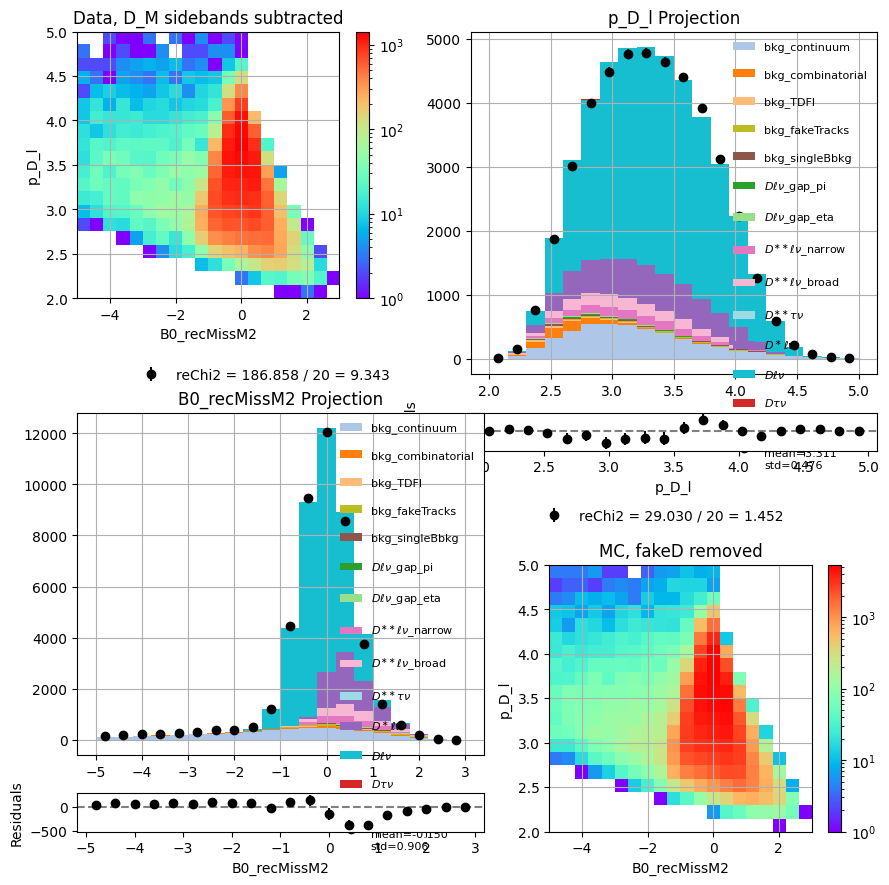

In [21]:
# e channel, lgb_loose
b_mm2 = np.linspace(-5,3,21)
b_pDl = np.linspace(2,5,21)
scale2 = {'data left sideband': 1550/1466/2,
         'data right sideband': 1550/1635/2,
         'data signal region': 1,
         'all_mc': 0.25}

par_dict={'var_list':['B0_recMissM2','p_D_l'],
          'bin_list': [b_mm2, b_pDl],
          'cut': 'B0_recQ2BhSimple<3', #'B0_roeMbc_my_mask>5.1 and -4<B0_roeDeltae_my_mask<1',
          'weights': scale2,
          'correction': False,
          'mask': ['bkg_fakeD']}
indices_threshold, temp_data = mpl.plot_data_subtracted_and_mc(**par_dict)

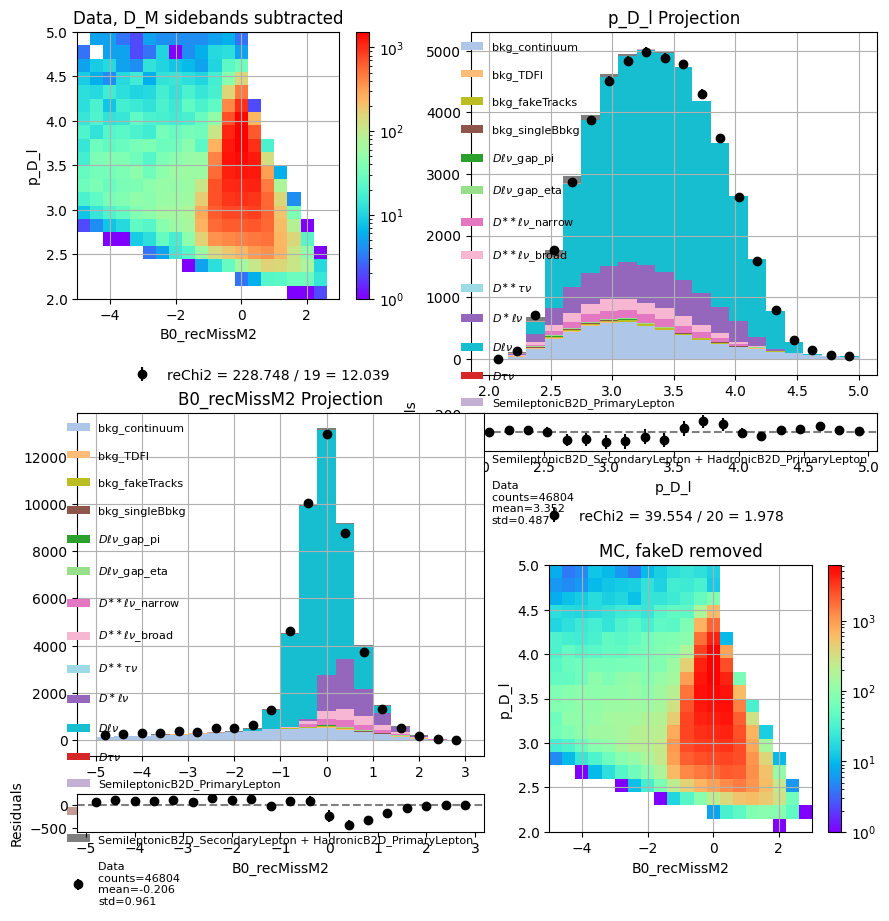

In [18]:
# e channel, lgb_loose
b_mm2 = np.linspace(-5,3,21)
b_pDl = np.linspace(2,5,21)

scale1 = {'data left sideband': 3713/3540/2,
         'data right sideband': 3713/3886/2,
         'data signal region': 1,
         'all_mc': 0.25,
         'bkg_singleBbkg':0.14,
         'HadronicB2D_SecondaryLepton': 0.1,}

par_dict={'var_list':['B0_recMissM2','p_D_l'],
          'bin_list': [b_mm2, b_pDl],
          'cut': 'B0_recQ2BhSimple<3', #'B0_roeMbc_my_mask>5.1 and -4<B0_roeDeltae_my_mask<1',
          'weights': scale1,
          'correction': False,
          'mask': ['bkg_fakeD']}
indices_threshold, temp_data = mpl_subcat.plot_data_subtracted_and_mc(**par_dict)

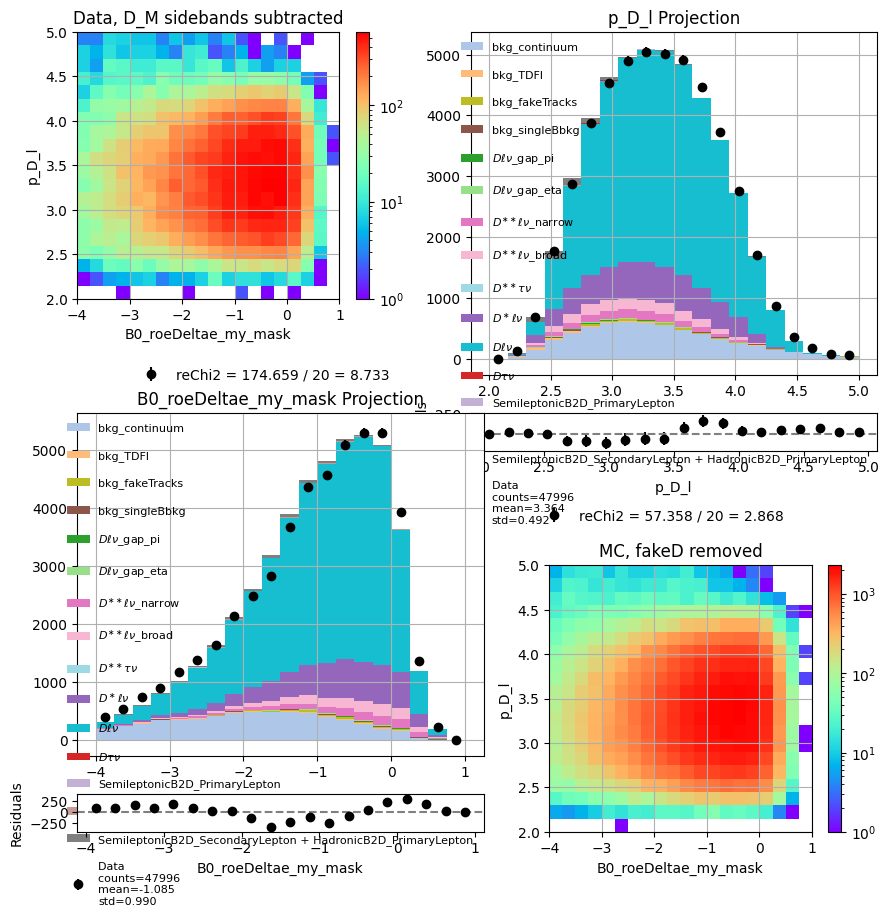

In [7]:
# e channel, lgb_loose
b_mm2 = np.linspace(-4,1,21)
b_pDl = np.linspace(2,5,21)

scale1 = {'data left sideband': 3713/3540/2,
         'data right sideband': 3713/3886/2,
         'data signal region': 1,
         'all_mc': 0.25,
         'bkg_singleBbkg':0.14,
         'HadronicB2D_SecondaryLepton': 0.1,}

par_dict={'var_list':['B0_roeDeltae_my_mask','p_D_l'],
          'bin_list': [b_mm2, b_pDl],
          'cut': 'B0_recQ2BhSimple<3', #'B0_roeMbc_my_mask>5.1 and -4<B0_roeDeltae_my_mask<1',
          'weights': scale1,
          'correction': False,
          'mask': ['bkg_fakeD']}
indices_threshold, temp_data = mpl_subcat.plot_data_subtracted_and_mc(**par_dict)

### 2. D* veto

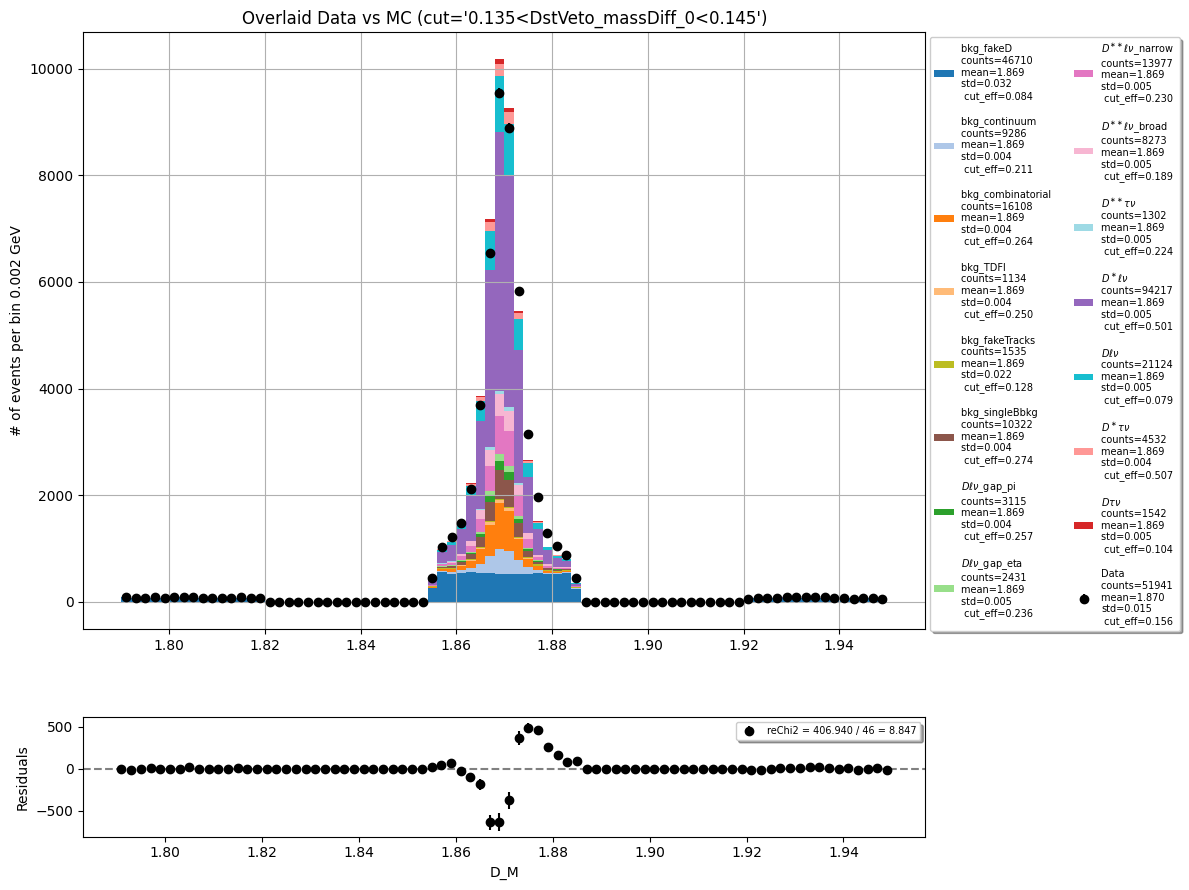

In [50]:
# showing the fake D and sidebands in D_M
b1 = np.linspace(1.79,1.95,81)
weights={'all_mc':0.22}
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='D_M',bins=b1,cut='0.135<DstVeto_massDiff_0<0.145',correction=False,mask=[],
    figsize=(12,9),ratio=False,legend_nc=2,legend_fs=7,
    weights=weights)

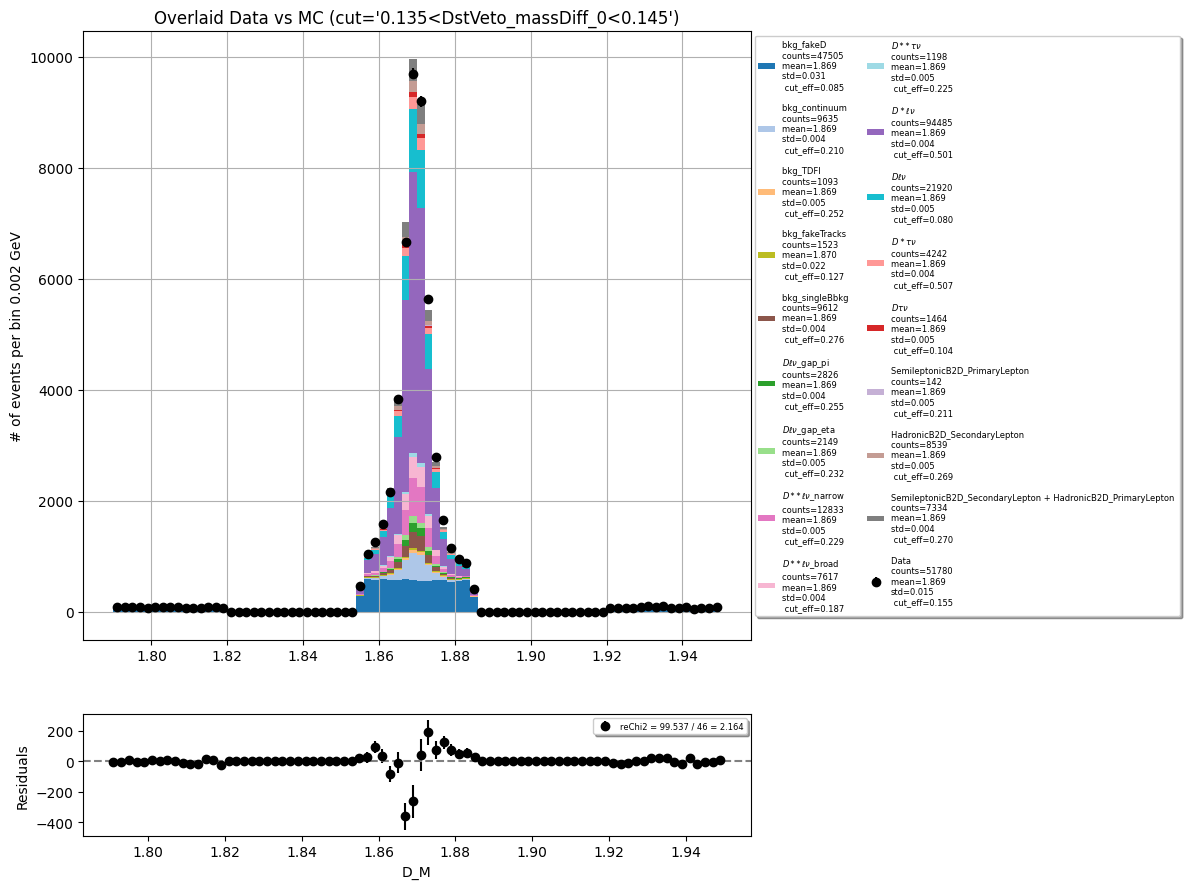

In [35]:
# showing the fake D and sidebands in D_M
b1 = np.linspace(1.79,1.95,81)
weights={'all_mc':0.23,'bkg_singleBbkg':0.14*23/25,'HadronicB2D_SecondaryLepton': 0.1*23/25,}
data_hist_all, mc_hist_all = mpl_subcat.plot_data_mc_stacked(
    variable='D_M',bins=b1,cut='0.135<DstVeto_massDiff_0<0.145',correction=False,mask=[],
    figsize=(12,9),ratio=False,legend_nc=2,legend_fs=6,weights=weights)

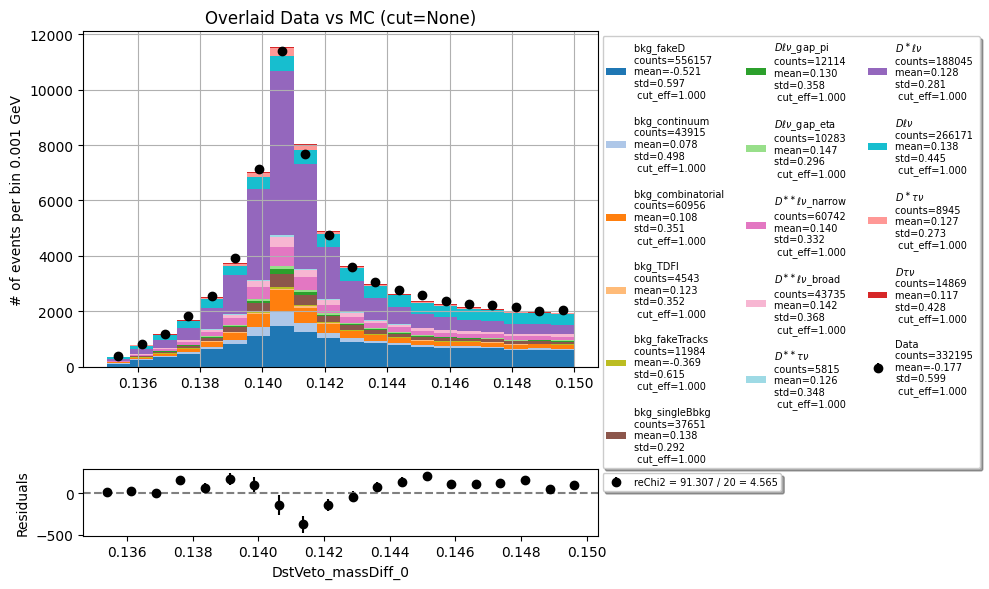

In [51]:
# e channel
b1 = np.linspace(0.135,0.15,21)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='DstVeto_massDiff_0',bins=b1,cut=None,
    correction=False,mask=[],figsize=(10,6),ratio=False,
    weights={'all_mc':0.22},legend_nc=3, legend_fs=7)

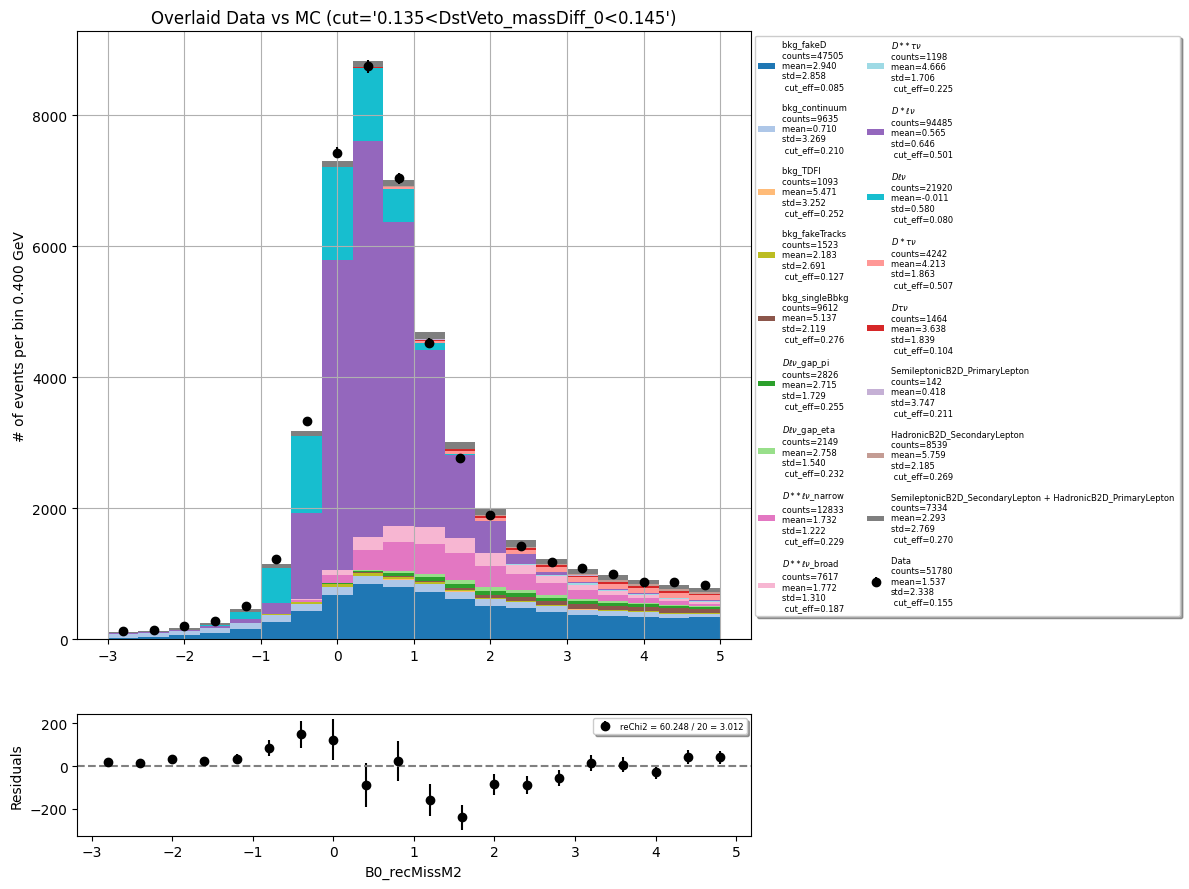

In [32]:
# e
b1 = np.linspace(-3,5,21)
a,b=mpl_subcat.plot_data_mc_stacked(variable='B0_recMissM2',bins=b1,figsize=(12,9),legend_nc=2, legend_fs=6,
                          cut='0.135<DstVeto_massDiff_0<0.145',correction=False,mask=[],ratio=False,
                          weights={'all_mc':0.23,'bkg_singleBbkg':0.14*23/25,'HadronicB2D_SecondaryLepton': 0.1*23/25,} )

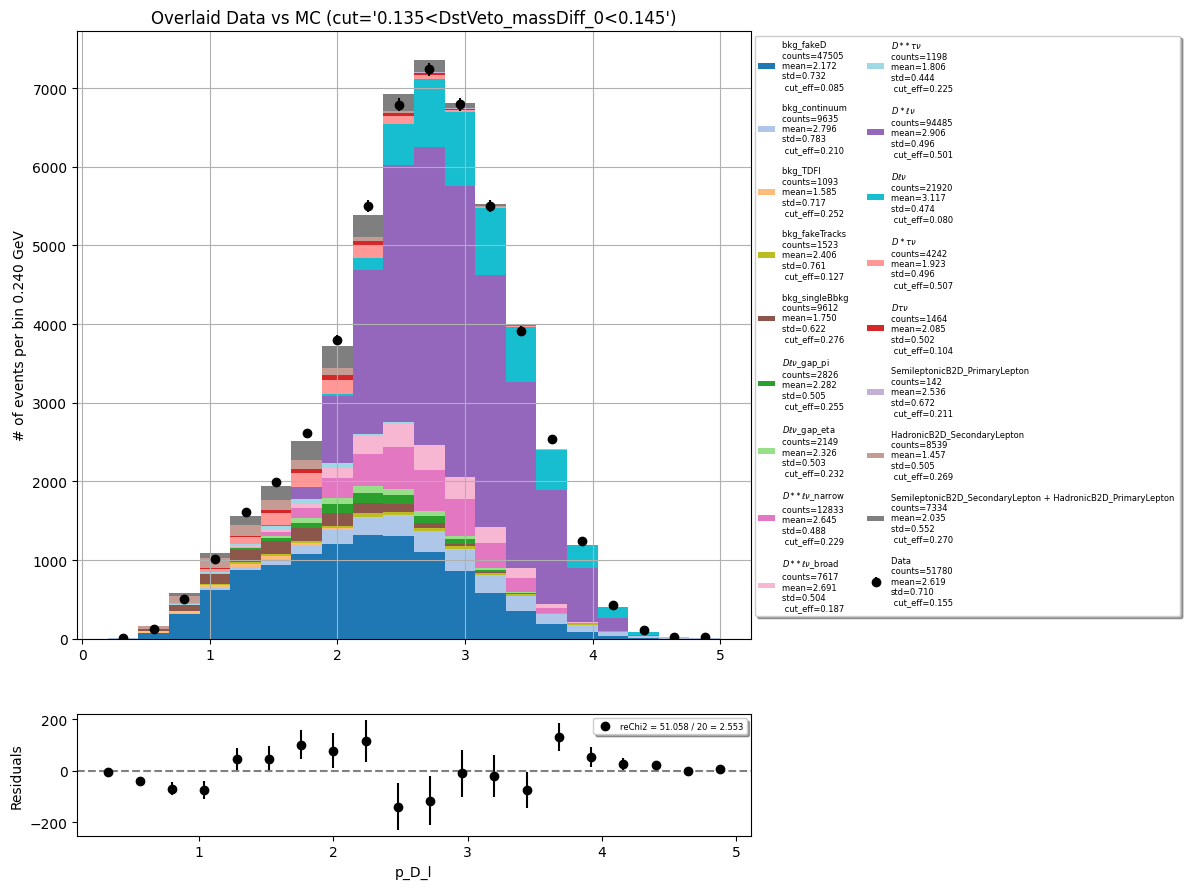

In [34]:
# e
b2 = np.linspace(0.2,5,21)
a,b=mpl_subcat.plot_data_mc_stacked(variable='p_D_l',bins=b2,figsize=(12,9),legend_nc=2, legend_fs=6,
                          cut='0.135<DstVeto_massDiff_0<0.145',correction=False,mask=[],ratio=False,
                          weights={'all_mc':0.23,'bkg_singleBbkg':0.14*23/25,'HadronicB2D_SecondaryLepton': 0.1*23/25,} )

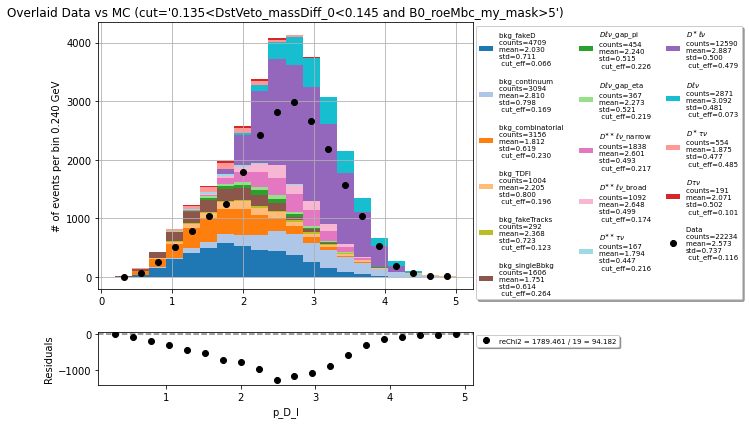

In [7]:
# e MC15ri
b2 = np.linspace(0.2,5,21)
a,b=mpl.plot_data_mc_stacked(variable='p_D_l',bins=b2,figsize=(10,6),
                          cut='0.135<DstVeto_massDiff_0<0.145 and B0_roeMbc_my_mask>5',
                          weights={'all_mc':187/200},correction=False,mask=[],ratio=False,
                          legend_nc=3, legend_fs=7)